# Critical Damping Regulator Design for Oscillator-like Systems
In this tutorial, we will introduce the `kontrol.regulator.feedback` module, and use `kontrol.regulator.feedback.critical_damping()` and `kontrol.regulator.feedback.proportional_derivative()` functions to algorithmically generate feedback controller that critically damps the system.

For critical damping of a oscillator, derivative controllers, i.e.
\begin{equation}
K_\mathrm{derivative}(s) = K_d s\,
\end{equation}
where $K_d$ is a the derivative gain, is sufficient for making a critically damped system.

Consider the damped-oscillator plant
\begin{equation}
P(s) = \frac{\omega_n^2}{s^2 + \frac{\omega_n}{Q} s + \omega_n^2}\,
\end{equation}
where $\omega_n$ is the resonance frequency (rad/s) of the oscillator, and $Q$ is the quality factor / Q-factor of the oscillator.

It's easy to show that if we would like to actively damp the oscillator to some desired Q value $Q_\mathrm{desired}$, then the corresponding required derivative gain is
\begin{equation}
K_d(Q_\mathrm{desired}) = \frac{\frac{1}{Q_\mathrm{desired}}-\frac{1}{Q}}{\omega_n^2\lvert P(0)\rvert}\,,
\end{equation}
for $Q_\mathrm{desired} \geq 0.5$.

`kontrol.regulator.feedback.critical_damp()` has argument `method` with options `"calculated"` and `"optimized"`.

For critical damping, the desired Q value is $Q_\mathrm{crit}=0.5$.
Furthermore, if we assume that the the Q value of the system is much greater than 0.5, then the critical damping gain can simply be approximated by
\begin{equation}
K_d = K_\mathrm{crit} = \frac{2}{\omega_n \lvert P(0)\rvert}\,,
\end{equation}
which is extremely easy to compute.

For coupled oscillators systems with more than one modes, the critical derivative gain can't be calculated easily, and we cannot achieve critical damping for all modes using only simple derivative damping.
If we only aim to critically damp the dominant mode, then the critical gain approximation is still valid, as we shall see later.

To find the the exact critical derivative gain, the `method="optimized"` is a better approach. It algorithically finds the derivative gain that makes the closed-loop system has one less complex pole pairs. And it finds the gain such that the complex pole pairs just becomes two simple poles, i.e. critically damped.

In this tutorial, we will design (algorithmically) the control system to damp a coupled oscillator system with two modes, i.e.

\begin{equation}
P(s) = G_1\frac{\omega_1^2}{s^2 + \omega_1/Q_1 s + \omega_1^2} + G_2\frac{\omega_2^2}{s^2 + \omega_2/Q_2 s + \omega_2^2}\,,
\end{equation}

and we will show the step reponse of the closed-loop response
\begin{equation}
\frac{P(s)}{1+K(s)P(s)}\,.
\end{equation}

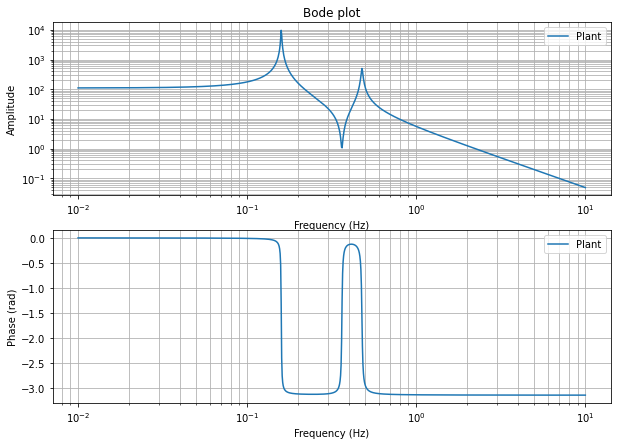

In [1]:
import numpy as np
import control
import matplotlib.pyplot as plt
import kontrol.regulator


s = control.tf("s")
g1 = 100
w1 = 1
q1 = 100
g2 = 10
w2 = 3
q2 = 50

plant = g1*w1**2 / (s**2 + w1/q1*s + w1**2) + g2*w2**2 / (s**2 + w2/q2*s + w2**2)

f = np.logspace(-2, 1, 1000)
plt.figure(figsize=(10, 7))
plt.subplot(211, title="Bode plot")
plt.loglog(f, abs(plant(1j*2*np.pi*f)), label="Plant")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")

plt.subplot(212)
plt.semilogx(f, np.angle(plant(1j*2*np.pi*f)), label="Plant")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")

Here, we will make two feedback regulators from `kontrol.regulator.feedback.critical_damping()`, one for `method="calculated"`, another one for `method="optimized"`.

In [2]:
k_calculated = kontrol.regulator.feedback.critical_damping(plant, method="calculated")
k_optimized = kontrol.regulator.feedback.critical_damping(plant)  # "optimized" is the default method
print("k_calculated: ", k_calculated)
print("k_optimized: ", k_optimized)

k_calculated:  
0.01818 s
---------
    1

k_optimized:  
0.01671 s
---------
    1



As can be seen, the approximated critical gain is very close to the optimized one.

Now, we check the open-loop transfer functions.

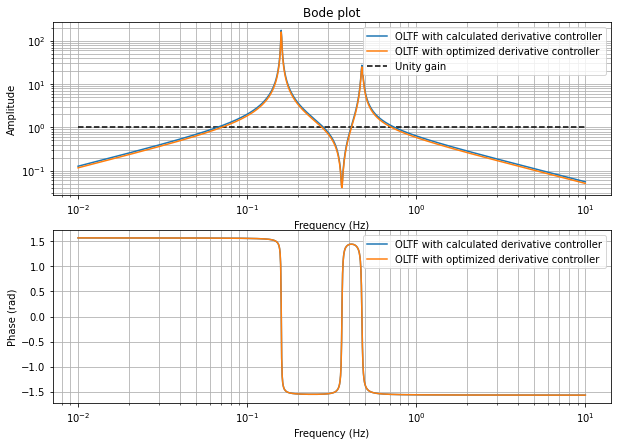

In [3]:
oltf_calculated = k_calculated * plant
oltf_optimized = k_optimized * plant

plt.figure(figsize=(10, 7))
plt.subplot(211, title="Bode plot")
plt.loglog(f, abs(oltf_calculated(1j*2*np.pi*f)), label="OLTF with calculated derivative controller")
plt.loglog(f, abs(oltf_optimized(1j*2*np.pi*f)), label="OLTF with optimized derivative controller")
plt.hlines(1, min(f), max(f), color="k", ls="--", label="Unity gain")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")

plt.subplot(212)
plt.semilogx(f, np.angle(oltf_calculated(1j*2*np.pi*f)), label="OLTF with calculated derivative controller")
plt.semilogx(f, np.angle(oltf_optimized(1j*2*np.pi*f)), label="OLTF with optimized derivative controller")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")

From now one we will consider the optimized version only.

Let's compare the open-loop and closed-loop frequency response.

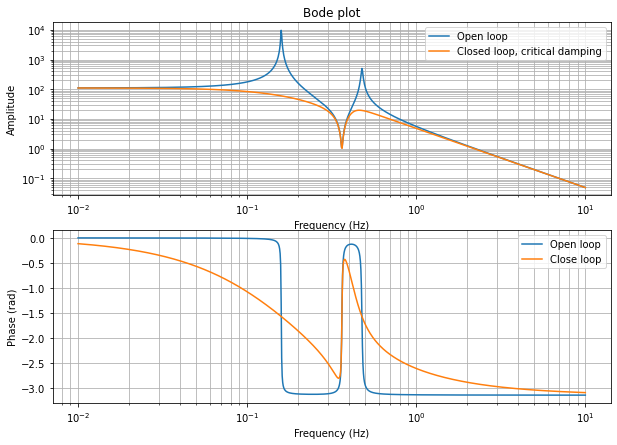

In [4]:
closed_loop = plant / (1+oltf_optimized)
k_overdamp = 2 * k_optimized
k_underdamp = 1/2 * k_optimized

closed_loop_overdamp = plant / (1 + k_overdamp*plant)
closed_loop_underdamp = plant / (1 + k_underdamp*plant)


plt.figure(figsize=(10, 7))
plt.subplot(211, title="Bode plot")
plt.loglog(f, abs(plant(1j*2*np.pi*f)), label="Open loop")
# plt.loglog(f, abs(closed_loop_overdamp(1j*2*np.pi*f)), label="Closed loop, overdamping")
# plt.loglog(f, abs(closed_loop_underdamp(1j*2*np.pi*f)), label="Closed loop, underdamping")
plt.loglog(f, abs(closed_loop(1j*2*np.pi*f)), label="Closed loop, critical damping")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")

plt.subplot(212)
plt.semilogx(f, np.angle(plant(1j*2*np.pi*f)), label="Open loop")
# plt.semilogx(f, np.angle(closed_loop_overdamp(1j*2*np.pi*f)), label="Closed loop, overdamping")
# plt.semilogx(f, np.angle(closed_loop_underdamp(1j*2*np.pi*f)), label="Closed loop, underdamping")
plt.semilogx(f, np.angle(closed_loop(1j*2*np.pi*f)), label="Close loop")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")

Let's show the root locus from 0 to `k_optimized` and you shall see how it works.

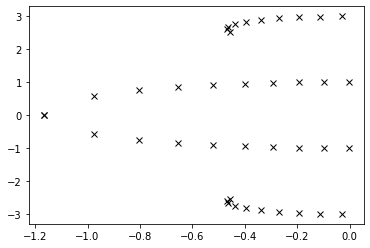

In [5]:
k_max = k_optimized.num[0][0][0]
for k in np.linspace(0, k_max, 10):
    plt.plot((plant/(1+k*s*plant)).minreal().pole().real, (plant/(1+k*s*plant)).minreal().pole().imag, "kx")

Here we compare the poles as well to show that one of the modes is critically damped.
(Look at the last two poles)

In [6]:
plant.pole()

array([-0.03 +2.99985j  , -0.03 -2.99985j  , -0.005+0.9999875j,
       -0.005-0.9999875j])

In [7]:
closed_loop.minreal().pole()

array([-0.45683853+2.5338248j, -0.45683853-2.5338248j,
       -1.16528417+0.j       , -1.16510385+0.j       ])

Now let's show the step-response.
We will also compare the cases that are slightly off critical gain.

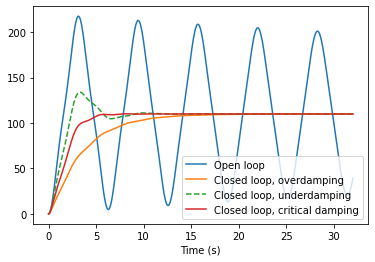

In [8]:
t = np.linspace(0, 32, 1024)

_, step_open_loop = control.step_response(plant, T=t)
_, step_closed_loop_overdamp = control.step_response(closed_loop_overdamp, T=t)
_, step_closed_loop_underdamp = control.step_response(closed_loop_underdamp, T=t)

_, step_closed_loop = control.step_response(closed_loop, T=t)


plt.plot(t, step_open_loop, label="Open loop")
plt.plot(t, step_closed_loop_overdamp, label="Closed loop, overdamping")
plt.plot(t, step_closed_loop_underdamp, "--", label="Closed loop, underdamping")
plt.plot(t, step_closed_loop, label="Closed loop, critical damping")
plt.legend(loc=0)
plt.xlabel("Time (s)")
plt.show()